# Adversarial ML
- FGSM attack
- PGD attack

# FGSM Attack on Toy 2D Problem
- model: logistic regression
- learning problem: toy binary classification with 2 input features

Here, notice how the inputs go to the other side of the boundary after we apply the perturbation. Of course, in this example the perturbation is very extreme. But we can exploit the same method on higher dimensional data with very small perturbations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a simple 2D binary classification dataset
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1, flip_y=0.1, class_sep=1.5, random_state=42)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate on clean test set
y_pred = model.predict(X_test)
clean_acc = accuracy_score(y_test, y_pred)

def fgsm_attack(X, y, model, epsilon=0.2):
    # activations need to be lowered for positive classes and increased for negative classes
    # to create adversarial examples
    class_sign = np.copy(y)
    class_sign[class_sign == 1] = -1
    class_sign[class_sign == 0] = 1

    grad_sign = np.sign(model.coef_)  # Sign of weights as gradient direction
    # create adversarial examples by adding the sign of the gradient to the input
    # epsilon controls the perturbation size
    return X + epsilon * class_sign.reshape(-1, 1) * grad_sign

# Generate adversarial examples
X_test_adv = fgsm_attack(X_test, y_test, model, epsilon=2)
y_pred_adv = model.predict(X_test_adv)
adv_acc = accuracy_score(y_test, y_pred_adv)

print(f"Accuracy on clean test set: {clean_acc:.2f}")
print(f"Accuracy on adversarial test set: {adv_acc:.2f}")

Accuracy on clean test set: 0.87
Accuracy on adversarial test set: 0.15


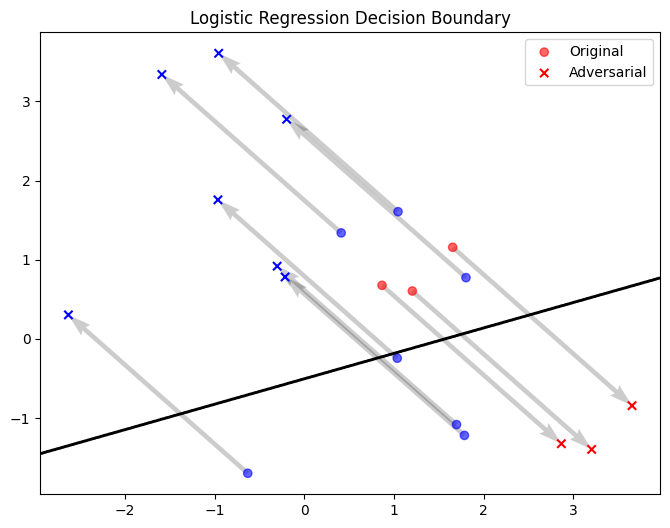

In [51]:
# Plot original and adversarial examples
def plot_boundary_and_points(X, y, X_adv=None):
    plt.figure(figsize=(8, 6))

    dx = X_adv[:, 0] - X[:, 0]
    dy = X_adv[:, 1] - X[:, 1]
    plt.quiver(X[:, 0], X[:, 1], dx, dy, angles='xy', scale_units='xy', scale=1, color='black', alpha=0.2)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, label='Original')

    if X_adv is not None:
        plt.scatter(X_adv[:, 0], X_adv[:, 1], c=y, cmap='bwr', marker='x', label='Adversarial')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, num=1000), np.linspace(*ylim, num=1000))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='black')
    plt.title('Logistic Regression Decision Boundary')
    plt.legend()
    plt.show()

plot_boundary_and_points(X_test[:10], y_test[:10], X_test_adv[:10])

# On MNIST
again, FGSM attack on logistic regression. However, this time we train on MNIST (binary classification). Due to the high dimensional input, we can find very small adversarial perturbations.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_openml

# Load MNIST dataset (only two classes for simplicity)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist['data']
y = mnist['target'].astype(np.int8)

# Use only digits 0 and 1 for binary classification
mask = (y == 0) | (y == 1)
X, y = X[mask], y[mask]

# Normalize and split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression with normalization
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

# Evaluate on clean data
y_pred = model.predict(X_test)
clean_acc = accuracy_score(y_test, y_pred)

# Extract weights from trained logistic regression model
clf = model.named_steps['logisticregression']
coef = clf.coef_

In [53]:
# FGSM attack
def fgsm_attack(X, class_sign, epsilon=0.2):
    grad_sign = np.sign(coef)  # Sign of weights as gradient direction
    return X + epsilon * class_sign.reshape(-1, 1) * grad_sign

class_sign = np.copy(y_test)
class_sign[class_sign == 1] = -1
class_sign[class_sign == 0] = 1

X_test_adv = fgsm_attack(X_test, class_sign, epsilon=10.0)
y_pred_adv = model.predict(X_test_adv)
adv_acc = accuracy_score(y_test, y_pred_adv)

print(f"clean acc: {clean_acc}")
print(f"adver acc: {adv_acc}")

clean acc: 0.9993234100135318
adver acc: 0.0


Notice the zero adversarial accuracy!

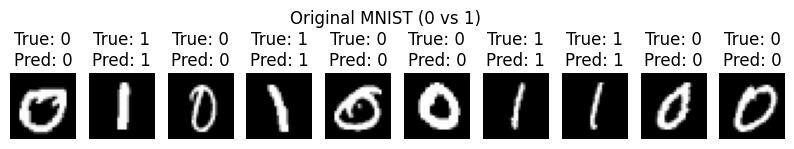

clean acc: 0.9993234100135318


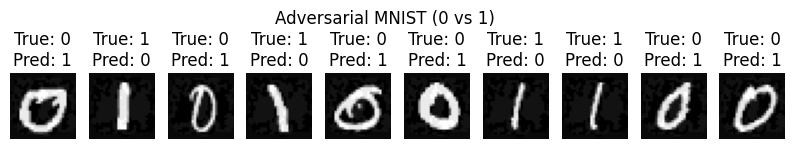

clean acc: 0.9993234100135318
adver acc: 0.0


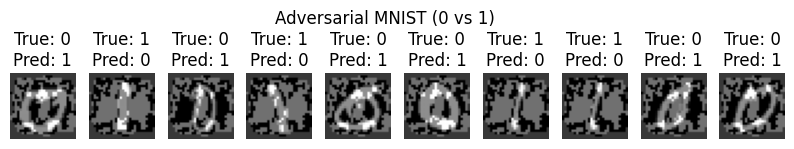

clean acc: 0.9993234100135318
adver acc: 0.0


In [54]:
# Plot some adversarial examples
def show_images(images, labels, pred, title, num=10):
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {labels[i]}\nPred: {pred[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(X_test, y_test, y_pred, "Original MNIST (0 vs 1)")
print(f"clean acc: {clean_acc}")

X_test_adv = fgsm_attack(X_test, class_sign, epsilon=10.0)
y_pred_adv = model.predict(X_test_adv)
show_images(X_test_adv, y_test, y_pred_adv, "Adversarial MNIST (0 vs 1)")
adv_acc = accuracy_score(y_test, y_pred_adv)
print(f"clean acc: {clean_acc}")
print(f"adver acc: {adv_acc}")

X_test_adv = fgsm_attack(X_test, class_sign, epsilon=100.0)
y_pred_adv = model.predict(X_test_adv)
show_images(X_test_adv, y_test, y_pred_adv, "Adversarial MNIST (0 vs 1)")
adv_acc = accuracy_score(y_test, y_pred_adv)
print(f"clean acc: {clean_acc}")
print(f"adver acc: {adv_acc}")


# PGD Attack

Logistic regression on binary MNIST. Since we need backprop, here we implement the model on pytorch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


# Define logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim=28*28, num_classes=2):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.linear(x)

# Load MNIST (digits 0 and 1 only)
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_idx = [i for i, (x, y) in enumerate(mnist_train) if y in [0, 1]]
test_idx = [i for i, (x, y) in enumerate(mnist_test) if y in [0, 1]]

train_loader = DataLoader(Subset(mnist_train, train_idx), batch_size=64, shuffle=True)
test_loader = DataLoader(Subset(mnist_test, test_idx), batch_size=64, shuffle=False)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogisticRegressionModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

# Train model
model.train()
for epoch in range(3):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# PGD Attack implementation
def pgd_attack(model, images, labels, eps=0.3, alpha=0.01, iters=40):
    """
    Args:
    - model: the model to attack
    - images: input images
    - labels: true labels for the images
    - eps: maximum perturbation
    - alpha: step size for each iteration
    - iters: number of iterations for the attack
    
    Returns:
    - adv_images: adversarial images
    """
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()
    
    # we iterate the attack for a number of iterations
    for i in range(iters):
        # set requires_grad to True for the images
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        # update the adversarial images
        adv_images = images + alpha * images.grad.sign()
        # PROJECTION STEP:
        # clip the perturbation to be within the epsilon ball
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        # clip the pixels to be within [0, 1]
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()

    return images

# Evaluate clean and adversarial
model.eval()
correct_clean = 0
correct_adv = 0
total = 0
examples = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    correct_clean += (pred == labels).sum().item()

    adv_images = pgd_attack(model, images, labels)
    adv_outputs = model(adv_images)
    _, adv_pred = torch.max(adv_outputs.data, 1)
    correct_adv += (adv_pred == labels).sum().item()

    if len(examples) < 5:
        examples.append((images.cpu(), adv_images.cpu(), labels.cpu(), pred.cpu(), adv_pred.cpu()))

    total += labels.size(0)

print(f"Accuracy on clean test set: {correct_clean / total:.2f}")
print(f"Accuracy on adversarial test set: {correct_adv / total:.2f}")



Accuracy on clean test set: 1.00
Accuracy on adversarial test set: 0.25


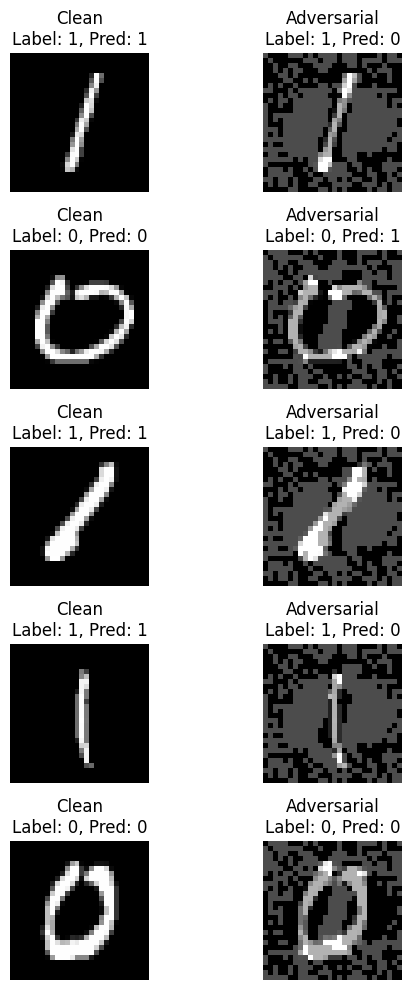

In [62]:
# Show a few examples
def show_example_comparison(examples):
    fig, axs = plt.subplots(len(examples), 2, figsize=(6, 10))
    for i, (orig, adv, label, pred, adv_pred) in enumerate(examples):
        axs[i, 0].imshow(orig[0].squeeze(), cmap='gray')
        axs[i, 0].set_title(f"Clean\nLabel: {label[0].item()}, Pred: {pred[0].item()}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(adv[0].squeeze(), cmap='gray')
        axs[i, 1].set_title(f"Adversarial\nLabel: {label[0].item()}, Pred: {adv_pred[0].item()}")
        axs[i, 1].axis('off')
    plt.tight_layout()

show_example_comparison(examples)

Notice the pattern in the adversarial examples:
- zeros are switched into ones by increasing the value of central pixels and decreasing the values where we expect high values for class zero
- the opposite happens for class one
- there is also some background noise due to spurious weights for non-informative, background pixels

# Adversarial Training

- CNN model
- PGD adversary

Unlike the previous cells of this notebook, you need to let this run for a big number of epochs before seeing some improvements in the adversarial robustness.

You can also check the following paper for in-depth empirical results:
Madry, A., Makelov, A., Schmidt, L., Tsipras, D., Vladu, A., 2019. Towards Deep Learning Models Resistant to Adversarial Attacks. https://doi.org/10.48550/arXiv.1706.06083


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_net(x)
        return self.fc(x)

# PGD attack
def pgd_attack(model, images, labels, eps=0.3, alpha=0.01, iters=40):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    for _ in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()

    return images

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transform),
                         batch_size=128, shuffle=False)

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Evaluation function
def evaluate(model, loader, attack=None):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        if attack:
            images = attack(model, images, labels)
        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


# Adversarial Training
model.train()
for epoch in range(200):  # Small number of epochs for demonstration
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Generate adversarial examples
        adv_images = pgd_attack(model, images, labels, eps=0.3, alpha=0.01, iters=7)
       
        # Train on adversarial examples
        outputs = model(adv_images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    acc_clean = evaluate(model, test_loader)
    acc_adv = evaluate(model, test_loader, attack=lambda m, x, y: pgd_attack(m, x, y, eps=0.3, alpha=0.01, iters=40))

    print(f"Epoch {epoch + 1}:")
    print(f"Accuracy on clean test set: {acc_clean:.2f}")
    print(f"Accuracy on adversarial test set: {acc_adv:.2f}\n")

Epoch 1:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.00

Epoch 2:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.00

Epoch 3:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.00

Epoch 4:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.00

Epoch 5:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.00

Epoch 6:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.03

Epoch 7:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.02

Epoch 8:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.01

Epoch 9:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.05

Epoch 10:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.02

Epoch 11:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.03

Epoch 12:
Accuracy on clean test set: 0.99
Accuracy on adversarial test set: 0.02

Epoch 13:
Acc

In [68]:
device

device(type='cuda')